
# Rational vs Adaptive Expectations
This notebook builds intuition for the **Rational Expectations (RE)** and **Adaptive Expectations (AE)** frameworks using a simple time series model.


### What we see in this notebook:
1. What an AR(1) process looks like.
2. How Rational and Adaptive expectations make forecasts.
3. How to measure forecast **Bias** and **Mean Squared Error (MSE)**.
4. Visual comparison of how these two expectations behave in different scenarios.

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)


## ***Creating a Simple AR(1) Process***
The AR(1) process represents a variable that depends partly on its previous value and partly on random noise.

$$x_t = \phi x_{t-1} + \varepsilon_t$$

Where $\phi$ measures persistence (0 = no memory, close to 1 = strong memory).


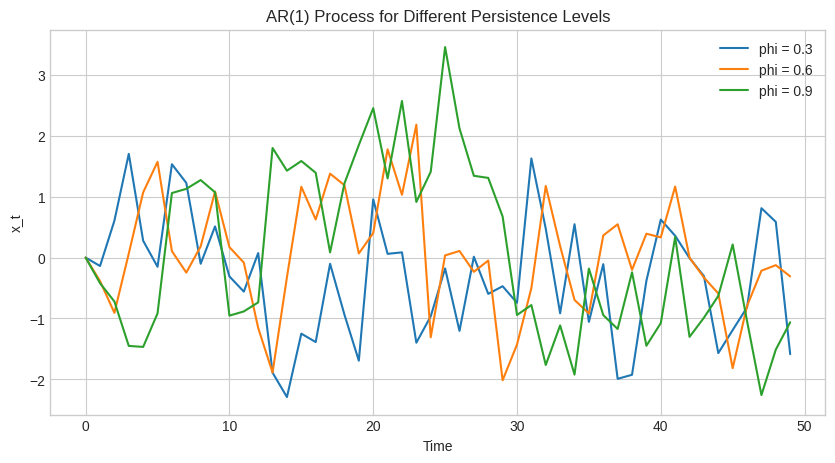

In [94]:
def simulate_ar1(phi=0.8, sigma=1.0, T=50):
    x = np.zeros(T)
    eps = np.random.normal(0, sigma, T)
    for t in range(1, T):
        x[t] = phi * x[t - 1] + eps[t]
    return x

phi_values = [0.3, 0.6, 0.9]
plt.figure(figsize=(10, 5))
for phi in phi_values:
    x = simulate_ar1(phi)
    plt.plot(x, label=f'phi = {phi}')
plt.title('AR(1) Process for Different Persistence Levels')
plt.xlabel('Time')
plt.ylabel('x_t')
plt.legend()
plt.show()


## ***Monte Carlo Simulation: Multiple AR(1) Paths***
This shows several random realizations of the same AR(1) process (same parameters).
Each line is one possible "path" the process can take due to randomness.

The idea of a Monte Carlo simulation is to repeat a random process many times
and study how the outcomes behave *on average*.

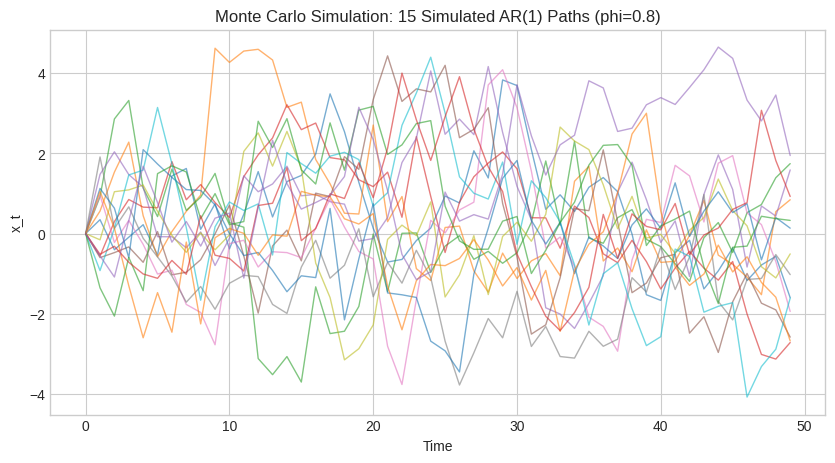

In [95]:
num_paths = 15     # number of simulated paths
T = 50             # time periods
phi = 0.8          # persistence
sigma = 1.0

plt.figure(figsize=(10, 5))
for i in range(num_paths):
    x = simulate_ar1(phi=phi, sigma=sigma, T=T)
    plt.plot(x, alpha=0.6, lw=1)
plt.title(f"Monte Carlo Simulation: {num_paths} Simulated AR(1) Paths (phi={phi})")
plt.xlabel("Time")
plt.ylabel("x_t")
plt.show()


## ***Forecasting Rules***

### **Rational Expectations (RE)**
If we know the true model parameter $\phi$, the best forecast is:

$$ \hat{x}_{t+1|t} ^{RE} = \phi x_t $$

### **Adaptive Expectations (AE)**
Forecasts are updated slowly based on the previous forecast and the latest observation:
$$f_t = f_{t-1} + \lambda (x_{t-1} - f_{t-1})$$
where $\lambda$ (0 < λ < 1) determines how fast people learn.


In [96]:
def rational_forecast(x, phi):
    forecast = phi * x[:-1]
    error = x[1:] - forecast
    return forecast, error

def adaptive_forecast(x, lam=0.3):
    f = np.zeros_like(x)
    f[0] = x[0]
    for t in range(1, len(x)):
        f[t] = f[t - 1] + lam * (x[t - 1] - f[t - 1])
    forecast = f[:-1]
    error = x[1:] - forecast
    return forecast, error


## ***Visual Comparison of Forecasts***
Let's compare how RE and AE behave on the same AR(1) series.


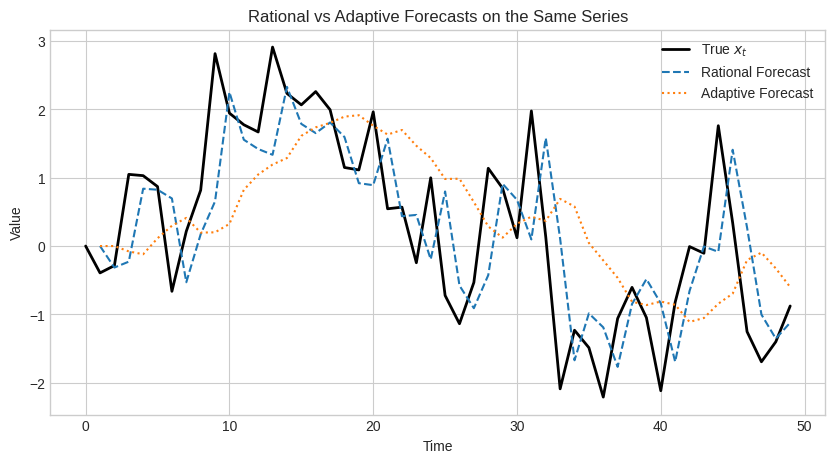

In [97]:
x = simulate_ar1(phi=0.8, T=50)
re_forecast, _ = rational_forecast(x, phi=0.8)
ae_forecast, _ = adaptive_forecast(x, lam=0.2)

plt.figure(figsize=(10, 5))
plt.plot(x, label='True $x_t$', linewidth=2, color='black')
plt.plot(range(1, len(x)), re_forecast, '--', color='tab:blue', label='Rational Forecast')
plt.plot(range(1, len(x)), ae_forecast, ':', color='tab:orange', label='Adaptive Forecast')
plt.title('Rational vs Adaptive Forecasts on the Same Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



## ***Bias and MSE Comparison***
In this section, we perform a **numerical Monte Carlo experiment**.  
We repeat the entire AR(1) simulation **many times** (e.g., 200 runs) for each combination of parameters and compute the **average Bias** and **Mean Squared Error (MSE)** for Rational and Adaptive forecasts.

This is the *same idea* as the previous Monte Carlo visualization but instead of plotting the paths, we now **quantify their average behavior**.  
This helps us see, statistically, which forecasting method performs better on average.


In [98]:
def run_experiment(phi=0.8, lam_values=[0.1, 0.3, 0.5], reps=200):
    results = []
    for lam in lam_values:
        bias_re, mse_re, bias_ae, mse_ae = [], [], [], []
        for _ in range(reps):
            x = simulate_ar1(phi)
            re_forecast, re_error = rational_forecast(x, phi)
            ae_forecast, ae_error = adaptive_forecast(x, lam)
            bias_re.append(np.mean(re_error))
            mse_re.append(np.mean(re_error**2))
            bias_ae.append(np.mean(ae_error))
            mse_ae.append(np.mean(ae_error**2))
        results.append({
            'lambda': lam,
            'bias_RE': np.mean(bias_re), 'MSE_RE': np.mean(mse_re),
            'bias_AE': np.mean(bias_ae), 'MSE_AE': np.mean(mse_ae)
        })
    return pd.DataFrame(results)

df = run_experiment(phi=0.8)
df


lambda   bias_RE    MSE_RE   bias_AE    MSE_AE
0     0.1 -0.007714  1.004216 -0.017993  2.213056
1     0.3  0.010938  1.009995  0.014439  2.069373
2     0.5 -0.005349  0.984774 -0.011820  1.872029

The table above shows the **average bias and MSE** across 200 Monte Carlo simulations for different learning rates (λ).  
Each row summarizes the performance of Rational (RE) and Adaptive (AE) forecasts under the same process.

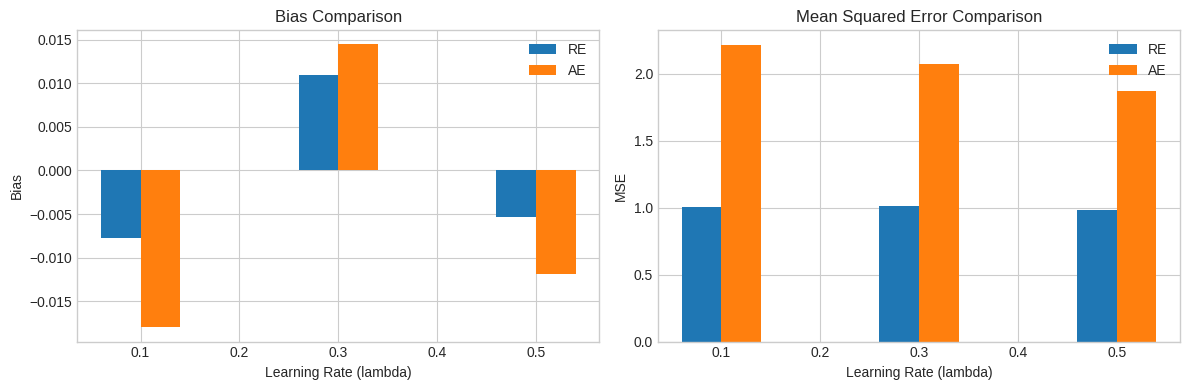

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(df['lambda'] - 0.02, df['bias_RE'], width=0.04, label='RE', color='tab:blue')
axes[0].bar(df['lambda'] + 0.02, df['bias_AE'], width=0.04, label='AE', color='tab:orange')
axes[0].set_title('Bias Comparison')
axes[0].set_xlabel('Learning Rate (lambda)')
axes[0].set_ylabel('Bias')
axes[0].legend()

axes[1].bar(df['lambda'] - 0.02, df['MSE_RE'], width=0.04, label='RE', color='tab:blue')
axes[1].bar(df['lambda'] + 0.02, df['MSE_AE'], width=0.04, label='AE', color='tab:orange')
axes[1].set_title('Mean Squared Error Comparison')
axes[1].set_xlabel('Learning Rate (lambda)')
axes[1].set_ylabel('MSE')
axes[1].legend()

plt.tight_layout()
plt.show()



### Interpretation
- **Bias:** Rational expectations (RE) forecasts are nearly unbiased (close to zero). Adaptive forecasts show small bias.
- **MSE:** RE is more accurate overall (lower MSE). AE gets worse as learning becomes slower (smaller λ).
- **Takeaway:** AE can approximate RE when λ is large and the process isn’t too persistent.


In [100]:
df.to_csv('Readable_RE_AE_Results.csv', index=False)
print('Results saved as Readable_RE_AE_Results.csv')


Results saved as Readable_RE_AE_Results.csv


## **Some Extra Stuff**

## Learning Speed (λ) and Forecast Accuracy

In the adaptive rule  
$$
f_t = f_{t-1} + \lambda (x_{t-1} - f_{t-1})
$$
λ measures how fast agents learn.  
We fix φ = 0.8 and vary λ to see how learning speed affects accuracy.

When λ is small, updates are slow and forecasts lag after shocks.  
As λ rises, expectations respond faster and the adaptive forecast approaches the rational one, lowering its MSE.


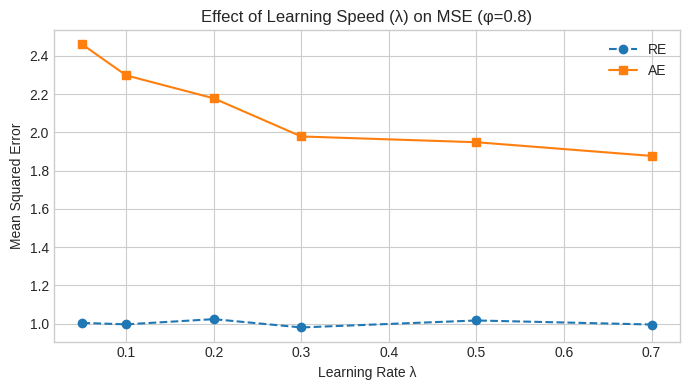

In [101]:
# Learning Speed
phi_target = 0.8
lam_values = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7]
df_learn = run_experiment(phi=phi_target, lam_values=lam_values, reps=200)
df_learn["phi"] = phi_target  # optional, just for completeness

plt.figure(figsize=(7,4))
plt.plot(df_learn["lambda"], df_learn["MSE_RE"], "o--", label="RE")
plt.plot(df_learn["lambda"], df_learn["MSE_AE"], "s-", label="AE")
plt.title(f"Effect of Learning Speed (λ) on MSE (φ={phi_target})")
plt.xlabel("Learning Rate λ")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.savefig("learning_speed_effect.png", dpi=300)
plt.show()

## Persistence (φ) and Forecast Performance

The AR(1) process  
$$
x_t = \phi x_{t-1} + \varepsilon_t
$$
shows how long shocks persist.  
We fix λ = 0.3 and vary φ to test how memory in the process affects forecasts.

For low φ, adaptive and rational forecasts perform similarly.  
As φ increases, shocks last longer and adaptive forecasts lag, widening the MSE gap.


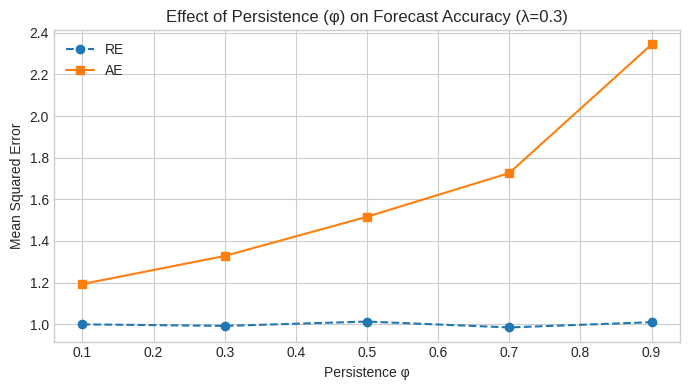

In [102]:
# Persistence effect at lambda = 0.3
lam_target = 0.3
phi_values = [0.1, 0.3, 0.5, 0.7, 0.9]

dfs = []
for p in phi_values:
    df_temp = run_experiment(phi=p, lam_values=[lam_target])
    df_temp["phi"] = p  # add the phi column manually
    dfs.append(df_temp)

df_persist = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(7,4))
plt.plot(df_persist["phi"], df_persist["MSE_RE"], "o--", label="RE")
plt.plot(df_persist["phi"], df_persist["MSE_AE"], "s-", label="AE")
plt.title(f"Effect of Persistence (φ) on Forecast Accuracy (λ={lam_target})")
plt.xlabel("Persistence φ")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.savefig("persistence_effect.png", dpi=300)
plt.show()
